In [1]:
import pandas as pd

In [2]:
from sqlalchemy import create_engine, text

In [3]:
import sys

# os.chdir('C:/Users/user/Documents/hs/pipeline-main/pipeline-main/')

sys.path.append('../py')

import data_processing as proc
import utils
import performance as perf


2024-05-16 08:10:50.302278: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 08:10:50.356811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import cx_Oracle
import os
os.putenv(' NLS_LANG', '.UTF8')

In [5]:
dsn = cx_Oracle.makedsn('192.168.1.5', '1521', service_name = 'ORA11')
con = cx_Oracle.connect('dbam', 'dbamkass', dsn = dsn, encoding="UTF-8")
cur = con.cursor()

In [6]:
sql_k200 = " select 일자, 종목코드2 종목코드, 종목명_국문 종목명, 당일가격, 지수내비중, 상장주식수, 유동비율, \
            지수주식수, 지수시가총액 \
             from KASS1.TH068 \
             where 익일적용여부 ='NXT' \
             and ISIN = 'KRD020020016' \
             order by 지수내비중 desc "

cur.execute(sql_k200)
k200_df = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])



In [7]:
k200_df['일자']=pd.to_datetime(k200_df['일자'], format ='%Y%m%d')
k200_df.set_index(['일자', '종목코드'], inplace=True)
k200_df.index.names=['Dates', 'Symbol']
k200_df.columns=['name', 'close', 'idx_weight', 'num_shares', 'float_rate', 'idx_num_shares', 'idx_cap']


In [8]:
k200_df=k200_df.sort_index(level='Dates')

In [9]:
host = '192.168.1.27'
port = '3306'
db_name = 'quantdb_maria'
username = 'quantdb'
password = 'QuantDb2023!'

engine = create_engine("mysql+pymysql://" + username + ":" + password + "@" + host + ":" + port + "/" + db_name)
conn=engine.connect()

In [10]:
period1='2014-09-01'
period2='2024-03-29'

In [11]:
query_COM=f"select * from COM_Table where Dates>='{period1}' and Dates<='{period2}'"
data_COM=pd.read_sql(query_COM, conn)

In [12]:
data_COM.set_index(['Dates','Symbol'], inplace=True)

In [13]:
data_COM_nodup=data_COM.loc[~data_COM.index.duplicated(keep='last')].copy()

In [14]:
query_SSC=f"select * from SSC_table_Bak where Dates>='{period1}' and Dates<='{period2}'"
data_SSC=pd.read_sql(query_SSC, conn)

In [15]:
data_SSC.set_index(['Dates','Symbol'], inplace=True)

In [16]:
data_SSC_nodup=data_SSC.loc[~data_SSC.index.duplicated(keep='last')].copy()

In [17]:
data_SSC.columns

Index(['Name', 'MNGT', 'ClosePrc', 'OpenPrc', 'HighPrc', 'LowPrc', 'AdjPrc',
       'AdjPrc2', 'AdjPrc_High_20D', 'AdjPrc_Low_20D', 'AdjPrc_High_60D',
       'AdjPrc_Low_60D', 'AdjPrc_High_120D', 'AdjPrc_Low_120D',
       'AdjPrc_High_52W', 'AdjPrc_Low_52W', 'ListedShares', 'ForeignStake',
       'TradeStop', 'MktCap_Comm_Pref', 'MktCapCom', 'MktCap', 'Volume',
       'Volume_Avg_20D', 'Volume_Avg_60D', 'Volume_Avg_120D', 'Volume_Avg_52W',
       'Amt_Avg_20D', 'Amt_Avg_60D', 'Amt_Avg_120D', 'Amt_Avg_52W', 'Vol_20D',
       'Vol_120D'],
      dtype='object')

In [18]:
data_COM.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [19]:
query_idx=f"select * from krx_idx"
krx_idx=pd.read_sql(query_idx, conn)

In [20]:
krx_idx.set_index('Dates', inplace=True)


<Axes: xlabel='Dates'>

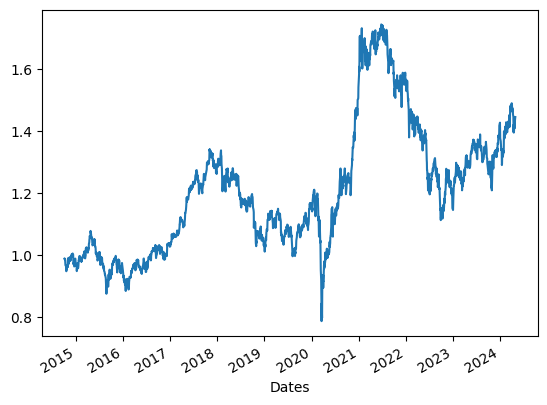

In [21]:
(1+krx_idx['코스피 200'].pct_change().loc['2014-10-02':]).cumprod().plot()

# backtesting

In [22]:
adjprc=data_SSC_nodup['AdjPrc'].unstack()
adjprc=adjprc.astype(float)

In [23]:
data_path='../data/output/prob_out/'
# file_name='multilayer_factor_rolling_v1.0_2024-03-29_ver0.1.csv'
file_name='prob_res_2014-01-29_2024-02-29_ver0.1.csv'
# hyungshin.lee/data/output/prob_out/prob_res_2013-01-25_2023-08-31.csv
raw_prob=pd.read_csv(data_path+file_name, index_col=0)

# mlq_w=pd.read_excel(data_path + 'monthly_port.xlsx', index_col=0)

In [24]:
raw_prob.index

Index(['2017-01-06', '2017-01-13', '2017-01-20', '2017-01-26', '2017-02-03',
       '2017-02-10', '2017-02-17', '2017-02-24', '2017-03-03', '2017-03-10',
       ...
       '2023-12-28', '2024-01-05', '2024-01-12', '2024-01-19', '2024-01-26',
       '2024-02-02', '2024-02-08', '2024-02-16', '2024-02-23', '2024-02-29'],
      dtype='object', name='Dates', length=373)

In [25]:
raw_prob

,A000030,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000210,A000230,...,A175330,A139130,A001570,A005420,A008730,A002710,A006110,A009970,A145720,A267260
Dates,,,,,,,,,,,,,,,,,,,,,
2017-01-06,0.202009,0.213429,0.206594,0.222489,0.192793,0.206674,0.187661,0.211250,0.209440,0.161159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-13,0.199454,0.212383,0.202911,0.221826,0.198615,0.207258,0.184772,0.210928,0.205835,0.161247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-20,0.197967,0.213269,0.202864,0.222847,0.200520,0.205254,0.183336,0.212298,0.204900,0.166422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-26,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-03,0.200100,0.211997,0.198505,0.221687,0.204146,0.204283,0.172575,0.211672,0.204807,0.174064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02,NaN,NaN,NaN,0.020217,0.025818,0.016344,NaN,0.022183,0.024446,NaN,...,0.023859,0.024005,0.020695,0.027580,0.021532,0.013047,0.021156,0.024797,0.027896,0.023444
2024-02-08,NaN,NaN,NaN,0.020032,0.025980,0.015417,NaN,0.022841,0.023763,NaN,...,0.025390,0.024822,0.021292,0.027748,0.026170,0.016089,0.021723,0.026376,0.028160,0.022096
2024-02-16,NaN,NaN,NaN,0.022642,0.026277,0.015752,NaN,0.023896,0.021194,NaN,...,0.025189,0.024910,0.021007,0.029489,0.033904,0.017759,0.025372,0.026740,0.028355,0.021878


In [26]:
# raw_prob.reset_index(inplace=True)
# raw_prob.set_index(['Dates', 'Symbol'], inplace=True)
# raw_prob=raw_prob.unstack()
# raw_prob.columns=raw_prob.columns.get_level_values(1)

In [27]:
raw_prob.index = pd.to_datetime(raw_prob.index)

<Axes: xlabel='Dates'>

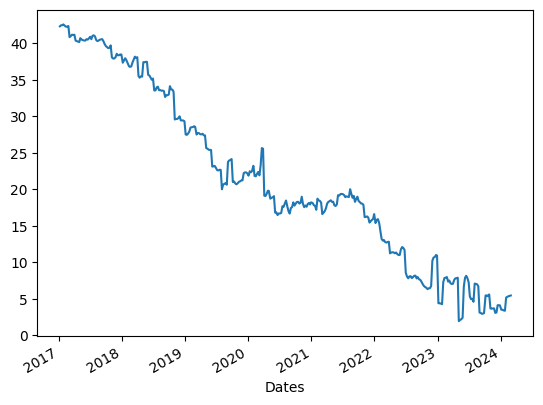

In [28]:
raw_prob.sum(1).plot()

<Axes: xlabel='Dates'>

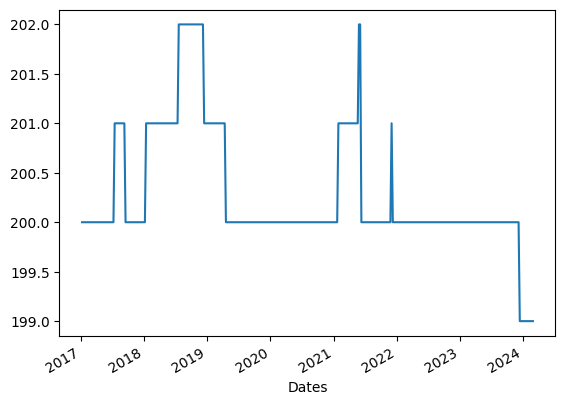

In [29]:
raw_prob.count(1).plot()

<Axes: xlabel='Dates'>

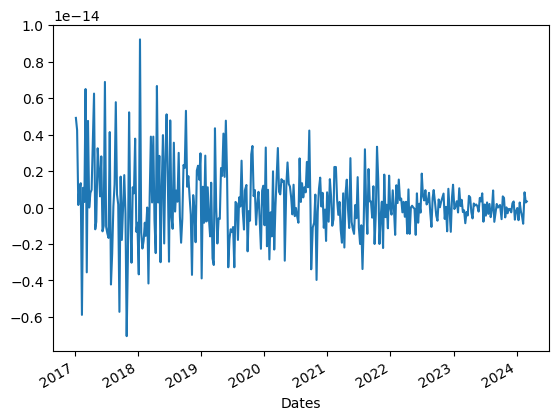

In [30]:
raw_prob.subtract(raw_prob.mean(1), axis=0).sum(1).plot()

In [31]:
# use existing weight with shift1

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [33]:
scaler = StandardScaler()
tempw = scaler.fit_transform(raw_prob.iloc[0].dropna().values.reshape(-1, 1))
temp_w = pd.DataFrame(tempw, index = raw_prob.iloc[0].dropna().index)

In [34]:
temp_w=temp_w/abs(temp_w).sum()

In [35]:
temp_w

,0
A000030,-0.004688
A000050,0.000918
A000070,-0.002437
A000080,0.005366
A000100,-0.009213
...,...
A170900,0.001668
A185750,0.003129
A192400,-0.004649
A192820,0.002418


In [36]:
raw_prob.iloc[-1].sort_values().dropna()

A000880    0.006596
A005930    0.009495
A139480    0.009790
A036460    0.011444
A001120    0.012125
             ...   
A039490    0.040236
A010620    0.040862
A383220    0.044656
A003410    0.049155
A003620    0.340030
Name: 2024-02-29 00:00:00, Length: 199, dtype: float64

In [37]:
ls_weight_ls = []
len_ls = []
for i in range(len(raw_prob.index)):
    scaler = StandardScaler()
    tempw = scaler.fit_transform(raw_prob.iloc[i].dropna().values.reshape(-1, 1))
    temp_w = pd.DataFrame(tempw, index = raw_prob.iloc[i].dropna().index)
    
    # remove top bottom +/- 2stdev
    temp_w[temp_w>(temp_w.mean()+2*temp_w.std())]=2
    temp_w[temp_w<(temp_w.mean()-2*temp_w.std())]=-2

    # remove in the middle
    # temp_w[(temp_w<temp_w.mean()+temp_w.std()) & (temp_w>temp_w.mean()-temp_w.std())]=0
    
    temp_w=temp_w/abs(temp_w).sum()
    len_ls.append(len(temp_w[temp_w>0].dropna()))
    ls_weight_ls.append(temp_w)
    

<Axes: >

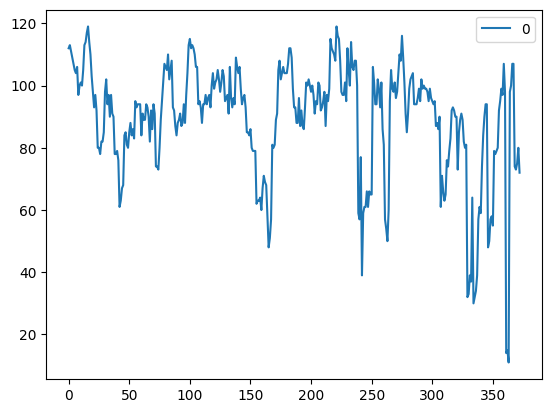

In [38]:
pd.DataFrame(len_ls).plot()

In [39]:
ls_w=pd.concat(ls_weight_ls, axis=1).T
ls_w.index=raw_prob.index

<Axes: >

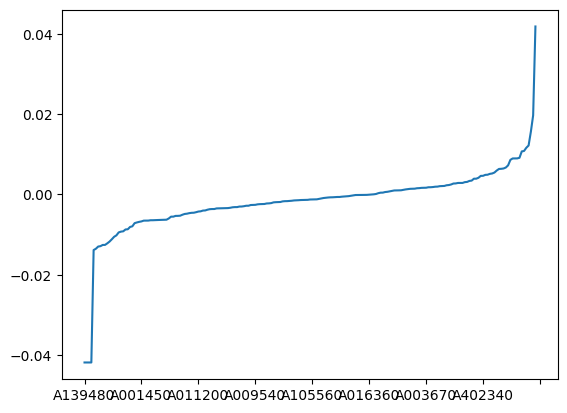

In [40]:
ls_w.iloc[-1].sort_values().dropna().plot()

In [41]:
temp_ls_w=ls_w.copy()
temp_ls_w.loc[:, 'A001570']=0

In [42]:
idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)

/tmp/ipykernel_18261/3876697821.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)


In [43]:
idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)

/tmp/ipykernel_18261/3876697821.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)


In [44]:
long_w=ls_w[temp_ls_w>0]
short_w=ls_w[temp_ls_w<0]

In [45]:
ew_long=long_w.copy()
ew_short=short_w.copy()

In [46]:
ew_long[ew_long>0]=1
ew_short[ew_short<0]=-1

In [47]:
ew_long=ew_long.div(ew_long.count(1), axis=0)
ew_short=ew_short.div(ew_short.count(1), axis=0)

<Axes: xlabel='Dates'>

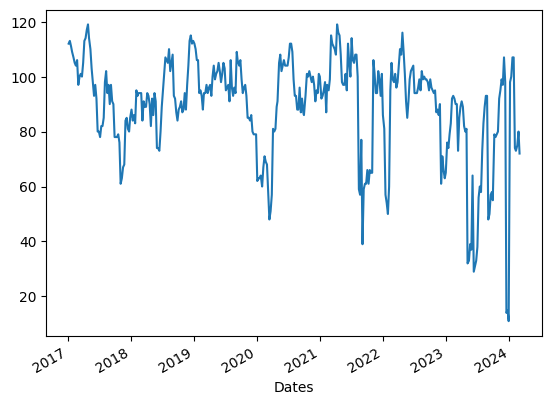

In [48]:
ew_long.count(1).plot()

In [49]:
long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*long_w.shift(1)*2
short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*short_w.shift(1)*2

/tmp/ipykernel_18261/425279764.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*long_w.shift(1)*2
/tmp/ipykernel_18261/425279764.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*short_w.shift(1)*2


In [50]:
ew_long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_long.shift(1)
ew_short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_short.shift(1)

/tmp/ipykernel_18261/4102127311.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  ew_long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_long.shift(1)
/tmp/ipykernel_18261/4102127311.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  ew_short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_short.shift(1)


# LS results

In [51]:
long_w.loc['2023-06-01': '2023-12-01', 'A001570'].fillna(0)

Dates
2023-06-02    0.0
2023-06-09    0.0
2023-06-16    0.0
2023-06-23    0.0
2023-06-30    0.0
2023-07-07    0.0
2023-07-14    0.0
2023-07-21    0.0
2023-07-28    0.0
2023-08-04    0.0
2023-08-11    0.0
2023-08-18    0.0
2023-08-25    0.0
2023-09-01    0.0
2023-09-08    0.0
2023-09-15    0.0
2023-09-22    0.0
2023-09-27    0.0
2023-10-06    0.0
2023-10-13    0.0
2023-10-20    0.0
2023-10-27    0.0
2023-11-03    0.0
2023-11-10    0.0
2023-11-17    0.0
2023-11-24    0.0
2023-12-01    0.0
Name: A001570, dtype: float64

/tmp/ipykernel_18261/1600025215.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  adjprc.pct_change().loc[ls_w.index, 'A001570'].plot()


<Axes: xlabel='Dates'>

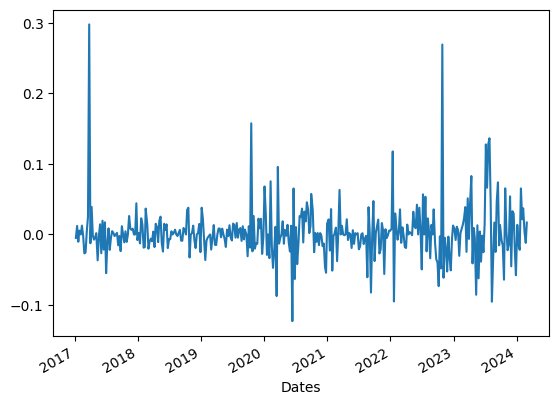

In [52]:
adjprc.pct_change().loc[ls_w.index, 'A001570'].plot()

In [53]:
ls_w.loc['2023-06-01':].index

DatetimeIndex(['2023-06-02', '2023-06-09', '2023-06-16', '2023-06-23',
               '2023-06-30', '2023-07-07', '2023-07-14', '2023-07-21',
               '2023-07-28', '2023-08-04', '2023-08-11', '2023-08-18',
               '2023-08-25', '2023-09-01', '2023-09-08', '2023-09-15',
               '2023-09-22', '2023-09-27', '2023-10-06', '2023-10-13',
               '2023-10-20', '2023-10-27', '2023-11-03', '2023-11-10',
               '2023-11-17', '2023-11-24', '2023-12-01', '2023-12-08',
               '2023-12-15', '2023-12-22', '2023-12-28', '2024-01-05',
               '2024-01-12', '2024-01-19', '2024-01-26', '2024-02-02',
               '2024-02-08', '2024-02-16', '2024-02-23', '2024-02-29'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [54]:
adjprc.loc[ls_w.loc['2023-06-01':].index, 'A001570'].pct_change()

Dates
2023-06-02         NaN
2023-06-09    0.132231
2023-06-16    0.100365
2023-06-23   -0.036484
2023-06-30   -0.086059
2023-07-07    0.563089
2023-07-14    0.220482
2023-07-21    0.208292
2023-07-28    0.095588
2023-08-04    0.158837
2023-08-11   -0.164093
2023-08-18   -0.016166
2023-08-25   -0.010172
2023-09-01   -0.005534
2023-09-08    0.082671
2023-09-15   -0.050661
2023-09-22   -0.013921
2023-09-27   -0.056471
2023-10-06   -0.084788
2023-10-13    0.062670
2023-10-20   -0.115385
2023-10-27   -0.118841
2023-11-03    0.009868
2023-11-10    0.090119
2023-11-17   -0.023904
2023-11-24    0.074490
2023-12-01    0.163343
2023-12-08   -0.053061
2023-12-15   -0.008621
2023-12-22   -0.052174
2023-12-28    0.001835
2024-01-05   -0.045788
2024-01-12   -0.043186
2024-01-19   -0.099298
2024-01-26   -0.109131
2024-02-02    0.007500
2024-02-08    0.040943
2024-02-16    0.133492
2024-02-23   -0.044164
2024-02-29    0.061606
Name: A001570, dtype: float64

In [55]:
idx_ret['A001570'].dropna()

Dates
2017-01-13   -0.0
2017-01-20   -0.0
2017-01-26   -0.0
2017-02-03   -0.0
2017-02-10   -0.0
             ... 
2024-02-02    0.0
2024-02-08    0.0
2024-02-16    0.0
2024-02-23   -0.0
2024-02-29    0.0
Name: A001570, Length: 372, dtype: float64

<Axes: xlabel='Dates'>

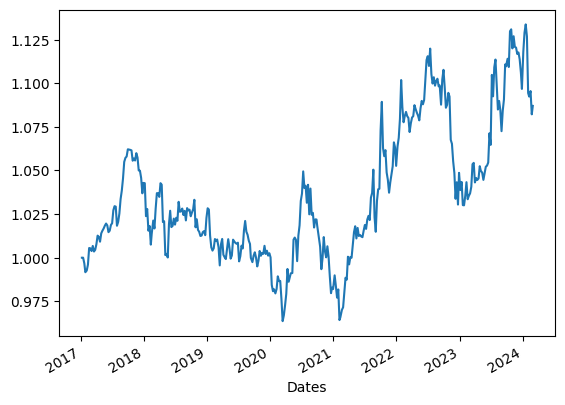

In [56]:
# raw long short 
(1+idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

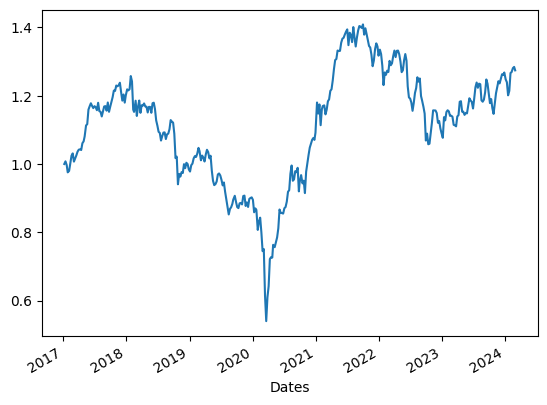

In [57]:
# raw long
(1+long_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

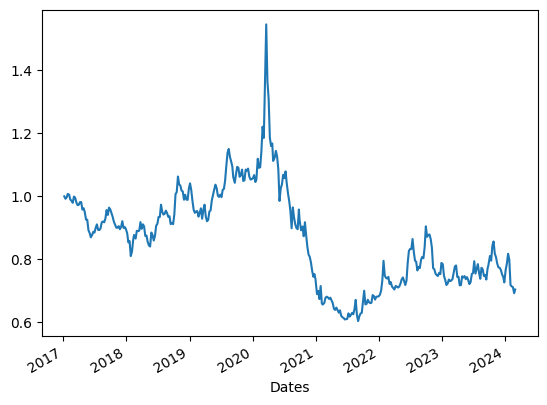

In [58]:
# raw short
(1+short_idx_ret.sum(1)).cumprod().plot()

In [59]:
# equal weight long short

<Axes: xlabel='Dates'>

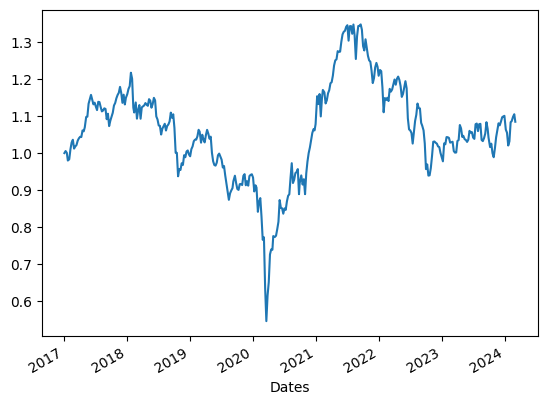

In [60]:
(1+ew_long_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

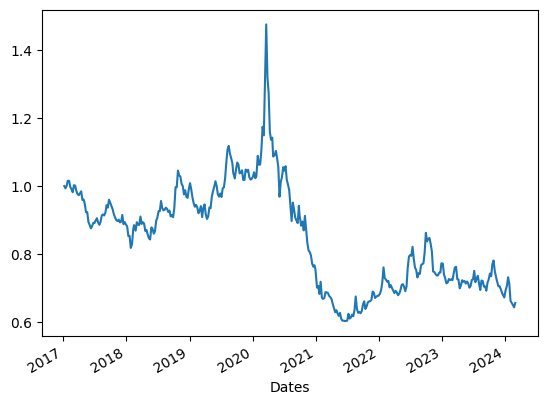

In [61]:
(1+ew_short_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

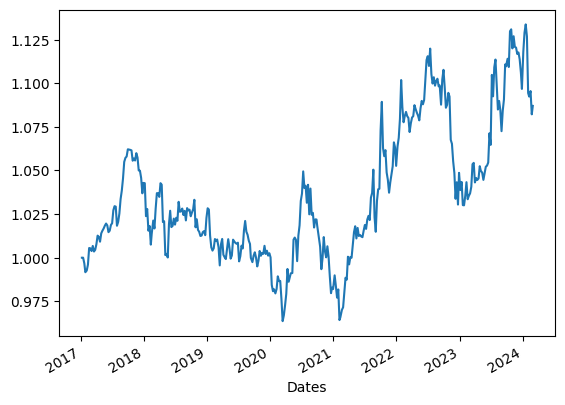

In [62]:
# remove top and bottom
(1+idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

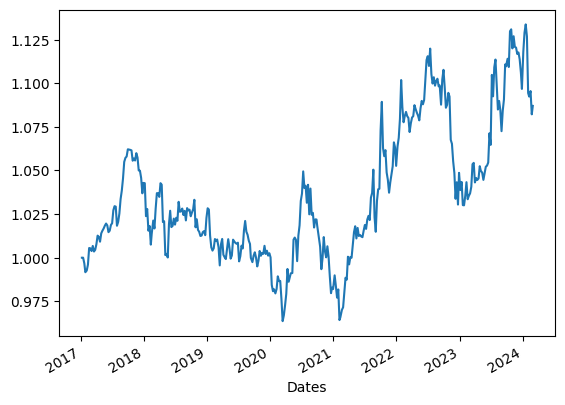

In [63]:
# remove in the middle
(1+idx_ret.sum(1)).cumprod().plot()

# optimize port

### how to optimize 
#### compare with market weight 
#### input: k200 weight, score, vol(return)


In [68]:
from scipy.optimize import minimize
import numpy as np

In [69]:
bmw=k200_df['idx_weight'].unstack()

In [70]:
adjprc.pct_change(60)

/tmp/ipykernel_18261/4222830641.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  adjprc.pct_change(60)


Symbol,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A460860,A462520,A465770,A900030,A900050,A900140,A950010,A950070,A950100,A950210
Dates,,,,,,,,,,,,,,,,,,,,,
2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,NaN,-0.036290,0.0,1.943820,-0.038117,0.0,0.022857,-0.118790,NaN,0.184755,...,-0.130961,-0.135731,-0.359014,NaN,0.0,0.135496,0.0,NaN,0.0,-0.050214
2024-03-26,NaN,-0.042169,0.0,2.026316,-0.037373,0.0,0.052857,-0.111349,NaN,0.164425,...,-0.117827,-0.130435,-0.308511,NaN,0.0,0.202358,0.0,NaN,0.0,-0.058252
2024-03-27,NaN,-0.046371,0.0,1.927746,-0.044218,0.0,0.049419,-0.061364,NaN,0.123711,...,-0.062041,-0.132048,-0.301626,NaN,0.0,0.189824,0.0,NaN,0.0,-0.094930


In [71]:
k200_df.index.get_level_values(0).unique()[k200_df.index.get_level_values(0).unique()>'2021-12-22']

DatetimeIndex(['2021-12-23', '2021-12-24', '2021-12-27', '2021-12-28',
               '2021-12-29', '2022-01-03', '2022-01-04', '2022-01-05',
               '2022-01-06', '2022-01-07',
               ...
               '2024-04-29', '2024-04-30', '2024-05-02', '2024-05-03',
               '2024-05-07', '2024-05-08', '2024-05-09', '2024-05-10',
               '2024-05-13', '2024-05-14'],
              dtype='datetime64[ns]', name='Dates', length=586, freq=None)

In [72]:
ls_w.index

DatetimeIndex(['2017-01-06', '2017-01-13', '2017-01-20', '2017-01-26',
               '2017-02-03', '2017-02-10', '2017-02-17', '2017-02-24',
               '2017-03-03', '2017-03-10',
               ...
               '2023-12-28', '2024-01-05', '2024-01-12', '2024-01-19',
               '2024-01-26', '2024-02-02', '2024-02-08', '2024-02-16',
               '2024-02-23', '2024-02-29'],
              dtype='datetime64[ns]', name='Dates', length=373, freq=None)

In [73]:
comm_dates=ls_w.index.intersection(k200_df.index.get_level_values(0).unique())
rebal_dates = proc.find_entire_rebalancing_dates(comm_dates)

lack of the beginning part of data  2016-12-31 00:00:00 2017-01-06 00:00:00
expected date is not in inner dates 2017-01-31 00:00:00
2017-01-31 00:00:00 2017-01-26 00:00:00
expected date is not in inner dates 2017-02-28 00:00:00
2017-02-28 00:00:00 2017-02-24 00:00:00
expected date is not in inner dates 2017-04-30 00:00:00
2017-04-30 00:00:00 2017-04-28 00:00:00
expected date is not in inner dates 2017-05-31 00:00:00
2017-05-31 00:00:00 2017-05-26 00:00:00
expected date is not in inner dates 2017-07-31 00:00:00
2017-07-31 00:00:00 2017-07-28 00:00:00
expected date is not in inner dates 2017-08-31 00:00:00
2017-08-31 00:00:00 2017-08-25 00:00:00
expected date is not in inner dates 2017-09-30 00:00:00
2017-09-30 00:00:00 2017-09-29 00:00:00
expected date is not in inner dates 2017-10-31 00:00:00
2017-10-31 00:00:00 2017-10-27 00:00:00
expected date is not in inner dates 2017-11-30 00:00:00
2017-11-30 00:00:00 2017-11-24 00:00:00
expected date is not in inner dates 2017-12-31 00:00:00
2017

In [74]:
rebal_dates

DatetimeIndex(['2017-01-26', '2017-02-24', '2017-03-31', '2017-04-28',
               '2017-05-26', '2017-06-30', '2017-07-28', '2017-08-25',
               '2017-09-29', '2017-10-27', '2017-11-24', '2017-12-28',
               '2018-01-26', '2018-02-23', '2018-03-30', '2018-04-27',
               '2018-05-25', '2018-06-29', '2018-07-27', '2018-08-31',
               '2018-09-28', '2018-10-26', '2018-11-30', '2018-12-28',
               '2019-01-25', '2019-02-28', '2019-03-29', '2019-04-26',
               '2019-05-31', '2019-06-28', '2019-07-26', '2019-08-30',
               '2019-09-27', '2019-10-25', '2019-11-29', '2019-12-27',
               '2020-01-31', '2020-02-28', '2020-03-27', '2020-04-29',
               '2020-05-29', '2020-06-26', '2020-07-31', '2020-08-28',
               '2020-09-29', '2020-10-30', '2020-11-27', '2020-12-30',
               '2021-01-29', '2021-02-26', '2021-03-26', '2021-04-30',
               '2021-05-28', '2021-06-25', '2021-07-30', '2021-08-27',
      

In [75]:
bmw

Symbol,A000030,A000050,A000060,A000070,A000080,A000100,A000120,A000140,A000150,A000210,...,A352820,A361610,A373220,A375500,A377300,A381970,A383220,A383800,A402340,A450080
Dates,,,,,,,,,,,,,,,,,,,,,
2016-06-02,0.46,0.03,NaN,0.1,0.12,0.39,0.28,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-03,0.45,0.03,NaN,0.1,0.11,0.40,0.29,0.01,0.11,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-07,0.45,0.03,NaN,0.1,0.11,0.39,0.30,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-08,0.45,0.03,NaN,0.1,0.11,0.40,0.30,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-09,0.44,0.03,NaN,0.1,0.11,0.39,0.29,0.02,0.11,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-08,NaN,NaN,NaN,NaN,0.05,0.35,0.12,NaN,0.09,0.05,...,0.30,0.12,1.12,0.09,0.2,NaN,0.09,NaN,0.59,0.10
2024-05-09,NaN,NaN,NaN,NaN,0.05,0.36,0.11,NaN,0.10,0.05,...,0.30,0.12,1.13,0.09,0.2,NaN,0.09,NaN,0.60,0.10
2024-05-10,NaN,NaN,NaN,NaN,0.05,0.35,0.11,NaN,0.09,0.05,...,0.30,0.12,1.10,0.09,0.2,NaN,0.09,NaN,0.61,0.10


In [76]:
ls_w.iloc[-1].describe()

count    199.000000
mean      -0.001727
std        0.008387
min       -0.041879
25%       -0.004335
50%       -0.001255
75%        0.001662
max        0.041879
Name: 2024-02-29 00:00:00, dtype: float64

In [81]:
import optuna

In [82]:
# study=optuna.create_study(direction='maximize')
# study.optimize(port_objective, n_trials=30)

In [83]:
# study.best_trials

In [84]:
data_COM_nodup.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [85]:
bmw.loc[rebal_dates[-1]]

Symbol
A000030     NaN
A000050     NaN
A000060     NaN
A000070     NaN
A000080    0.05
           ... 
A381970     NaN
A383220    0.10
A383800     NaN
A402340    0.57
A450080    0.19
Name: 2024-02-29 00:00:00, Length: 299, dtype: float64

In [86]:
pd.concat([data_COM_nodup.loc[rebal_dates[-1], 'FG_Sector_Idx'], bmw.loc[rebal_dates[-1]]], axis=1).groupby('FG_Sector_Idx').sum()

,2024-02-29 00:00:00
FG_Sector_Idx,
IT,47.12
경기소비재,11.00
금융,11.41
산업재,10.38
소재,7.72
에너지,2.38
유틸리티,0.82
의료,5.14
통신서비스,1.67


In [87]:
import warnings
warnings.simplefilter('error', RuntimeWarning)

In [88]:
rebal_dates

DatetimeIndex(['2017-01-26', '2017-02-24', '2017-03-31', '2017-04-28',
               '2017-05-26', '2017-06-30', '2017-07-28', '2017-08-25',
               '2017-09-29', '2017-10-27', '2017-11-24', '2017-12-28',
               '2018-01-26', '2018-02-23', '2018-03-30', '2018-04-27',
               '2018-05-25', '2018-06-29', '2018-07-27', '2018-08-31',
               '2018-09-28', '2018-10-26', '2018-11-30', '2018-12-28',
               '2019-01-25', '2019-02-28', '2019-03-29', '2019-04-26',
               '2019-05-31', '2019-06-28', '2019-07-26', '2019-08-30',
               '2019-09-27', '2019-10-25', '2019-11-29', '2019-12-27',
               '2020-01-31', '2020-02-28', '2020-03-27', '2020-04-29',
               '2020-05-29', '2020-06-26', '2020-07-31', '2020-08-28',
               '2020-09-29', '2020-10-30', '2020-11-27', '2020-12-30',
               '2021-01-29', '2021-02-26', '2021-03-26', '2021-04-30',
               '2021-05-28', '2021-06-25', '2021-07-30', '2021-08-27',
      

In [876]:
def score_objective(weight, bm_weight, score, cov):
    w_diff=abs(weight-bm_weight)
    if w_diff.sum()==0:
        return 0
    try:
        # Check for specific error message before sqrt
        if np.any(np.isnan(np.dot(w_diff.T, np.dot(cov, w_diff)))):
            raise ValueError("Encountered NaN values during portfolio volatility calculation.")
        port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
    
    except (ValueError, RuntimeWarning) as e:
        print(w_diff.isin([np.inf, -np.inf]).any().any())
        print(cov.isin([np.inf, -np.inf]).any().any())
        print(np.dot(cov, w_diff))
        print(np.dot(w_diff.T, np.dot(cov, w_diff)))
        print("Warning: Encountered errors during portfolio volatility calculation.")
        print(e)
    
    adj_sharpe=(w_diff*score).sum() / port_vol
    return -adj_sharpe


def handle_missingCol(port_df, bm_df):
    """
        compare given port column and BM column
    """
    missing_cols = set(bm_df.index) - set(port_df.index)

    if len(missing_cols)>0:
    # if method=='fill':
        
        # Add the missing columns to df1 with NaN values
        for col in missing_cols:
            print('missing col: ', col)
            # df1.loc[col] = pd.Series([None] * len(df1), index=df1.index)
            port_df.loc[col]=None
        # port_df=port_df.loc[bm_df.index]
        
    # elif len(bm_df.index) < len(port_df.index):
        # elif method=='drop':
        # comm_col=port_df.index.intersection(bm_df.index)
        # port_df=port_df.loc[comm_col]
    
    port_df=port_df.loc[bm_df.index]
        
    print(f"port shape: {port_df.shape}, bm shape: {bm_df.shape}, compare : {(port_df.index==bm_df.index).sum()}")
    return port_df


def convert_lsScore(port_score, short_num, long_num):
    """
        when score is all positive, it convert to the mean of score is 0 so that it can be used in Long/Short       
    """
    # convert into L/S scores
    sort_score=port_score.sort_values().dropna().copy()
    port_score[:]=np.nan # port_score.mean()
    if short_num>0:
        port_score[sort_score.iloc[:short_num].index]=sort_score.iloc[:short_num]

    port_score[sort_score.iloc[-long_num:].index]=sort_score.iloc[-long_num:]       
    # port_score=port_score.fillna(0)
    
    return port_score


def create_sectorMatrix(temp_bm_sectorw, temp_bm_stockw):

    # sector constraints variables       
    sector_mapping = {sector: idx for idx, sector in enumerate(temp_bm_sectorw.index)}

    A = np.zeros((len(temp_bm_sectorw), len(temp_bm_stockw)), dtype=int)
    for i, stock in enumerate(temp_bm_stockw.index):
        sector_idx = sector_mapping[temp_bm_stockw.loc[temp_bm_stockw.index == stock, 'sector'].iloc[0]]
        A[sector_idx, i] = 1
    
    return A

def create_excludingMatrix(temp_port_score):
    # B = np.eye(len(temp_port_score))
    # B[temp_port_score.isnull()] = 0
    B = np.zeros(len(temp_port_score))
    
    # Set entries corresponding to non-selected stocks (e.g., those with NaN scores) to 0
    B[temp_port_score.isnull()] = 1
        
    return B

def optimize_portfolio_(raw_score, bm_weight, sector_info, rebal_dates, long_num, short_num, excess_stockw, excess_sectorw):
    
    optw_ls=[]
    for rebal_date in rebal_dates:
        print(rebal_date)
        # slice BM weight
        temp_bm_weight=bm_weight.loc[rebal_date].dropna()
#        temp_bm_weight=temp_bm_weight.fillna(0)/
        temp_bm_weight=temp_bm_weight/temp_bm_weight.sum()
        print('005930 weight: ' ,temp_bm_weight.loc['A005930'])
        
        temp_raw_score=raw_score.loc[rebal_date].dropna()
        
        # slice port weight
        temp_port_score=handle_missingCol(temp_raw_score, temp_bm_weight)
        temp_port_score=temp_port_score.fillna(0)

        # convert score into long/short score
        temp_score=convert_lsScore(temp_port_score, short_num, long_num)
        print('l/s num: ', temp_score.dropna().shape)

        zero_idx= np.where(temp_score.isna())
        mask = np.ones_like(temp_score, dtype=bool)
        mask[zero_idx] = False        
        
        print('zero idx: ', len(zero_idx[0]))        
        # B=create_excludingMatrix(temp_score)
        # print(B.shape, B.sum())        
        # exclude_idx = np.where(temp_score.isna())
        # print('excl shape: ', exclude_idx[0].shape)
        # print("Indices of NaN values:", temp_score[temp_score.isna()].index)

        bounds = []
        k=0
        for i, value in enumerate(temp_score):
            if mask[i]:
                bounds.append((0, 1))  # Optimize this value
            else:                
                # print(k)
                bounds.append((0, 0))  # Set this value to 0
                k+=1

        # compute covariance
        temp_cov=adjprc.loc[:rebal_date, temp_score.index].pct_change(20).dropna(how='all', axis=0).cov()
        temp_cov=temp_cov.fillna(0)
               
        # load sector weight info
        # temp_bm_sector=data_COM_nodup.loc[rebal_date, 'FG_Sector_Idx']
        # temp_bm_sector=data_COM_nodup.loc[rebal_date, 'FG_Sector_Idx'].unstack().ffill().stack()

        # concat with bm stock weights include all stocks in BM 
        # to compute sector weights, all BM stocks required
        # excluding matrix so that it does not include not picked up stocks
        
        temp_bm_stockw=pd.concat([sector_info.loc[rebal_date].dropna(), temp_bm_weight], axis=1)
        temp_bm_stockw.columns=['sector', 'bm_weight']
        temp_bm_stockw=temp_bm_stockw.loc[temp_port_score.index]
        temp_bm_sectorw=temp_bm_stockw.groupby('sector').sum()
        print(temp_bm_sectorw)
        A=create_sectorMatrix(temp_bm_sectorw, temp_bm_stockw)
        
        # Define the constraints (weights sum to 1)
        const1 = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        # const11 = {'type': 'eq', 'fun': lambda x: np.sum(B*x).sum()}
        # const111= {'type': 'eq', 'fun': lambda x: np.array([x[i] for i in exclude_idx[0]])}
        const2 = {'type': 'ineq', 'fun': lambda x: -np.abs(x - temp_bm_weight)+excess_stockw}
        const3 = {'type': 'ineq', 'fun': lambda x: -np.abs(np.dot(A, x) - temp_bm_sectorw.values.flatten()) + excess_sectorw}
        
        # Define the bounds (each weight is between 0 and 1)
        # bounds = tuple((0, 1) for asset in range(len(temp_score.index)))

        constraints=[const1, const2, const3] #+sec_ub+sec_lb

        # Initial guess (equal weights)

        # print(len(temp_score.index), mask.sum(), ~mask.sum())
        initial_guess = np.array([1 / mask.sum() for _ in range(len(temp_score.index))])
        initial_guess[~mask] = 0
        # initial_guess=np.dot(B, initial_guess)
        # initial_guess = temp_bm_weight[mask]
        
        # Perform the optimization
        print(temp_bm_weight.shape, temp_score.shape, temp_cov.shape)
        result = minimize(score_objective, initial_guess, args=(temp_bm_weight, temp_score, temp_cov),
                          method='SLSQP', bounds=bounds, constraints=constraints) # 
        
        # Extract the optimized weights
        optimal_weights = result.x
        print('minimized value: ', result.fun)
        optw_df=pd.DataFrame(optimal_weights, index=temp_score.index, columns=[rebal_date])
        optw_ls.append(optw_df)
        # print("Optimal Weights:", optimal_weights)
    
    optw_port=pd.concat(optw_ls, axis=1).T
    daily_optw=pd.DataFrame(None, index=adjprc.loc[optw_port.index[0]:optw_port.index[-1]].index, columns=optw_port.columns)
    daily_optw.loc[optw_port.index]=optw_port.fillna(0)
    daily_optw=daily_optw.ffill()

    # daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
    # daily_opt_cumret=(1+daily_opt_port_ret.sum(1)).cumprod()

    return daily_optw
        

In [877]:
sector_label=data_COM_nodup.loc[rebal_dates, 'FG_Sector_Idx']
sector_label=sector_label.unstack().ffill().stack()

In [878]:
long_num=75
short_num=30
stockw=.03
sectorw=.05

In [879]:
rebal_dates[72]

Timestamp('2023-01-27 00:00:00')

In [880]:
daily_optw=optimize_portfolio_(ls_w, bmw, sector_label, rebal_dates[72:73], long_num, short_num, stockw, sectorw)

2023-01-27 00:00:00
005930 weight:  0.2875137458762371
missing col:  A175330
port shape: (200,), bm shape: (200,), compare : 200
l/s num:  (105,)
zero idx:  95
        bm_weight
sector           
IT       0.478856
경기소비재    0.105368
금융       0.108667
산업재      0.091473
소재       0.087774
에너지      0.025892
유틸리티     0.007698
의료       0.043887
통신서비스    0.017395
필수소비재    0.032990
(200,) (200,) (200, 200)
minimized value:  -0.11907625985066173


In [675]:
daily_optw=optimize_portfolio_(ls_w, bmw, sector_label, rebal_dates[72:73], long_num, short_num, stockw, sectorw)

2023-01-27 00:00:00
0.2875137458762371
missing col:  A175330
port shape: (200,), bm shape: (200,), compare : 200
bm adj score:  (200,) (199,)
l/s num:  (105,)
(200,) 95.0
        bm_weight
sector           
IT       0.478856
경기소비재    0.105368
금융       0.108667
산업재      0.091473
소재       0.087774
에너지      0.025892
유틸리티     0.007698
의료       0.043887
통신서비스    0.017395
필수소비재    0.032990
(200,) (200,) (200, 200)
minimized value:  -0.21880833199957922


In [881]:
daily_optw.iloc[-1].sort_values()

Symbol
A012750    0.000000
A017800    0.000000
A017670    0.000000
A016380    0.000000
A086790    0.000000
             ...   
A032830    0.035795
A015760    0.035998
A036570    0.038390
A033780    0.038929
A000660    0.048389
Name: 2023-01-27 00:00:00, Length: 200, dtype: float64

In [882]:
daily_optw.sum(1)

Dates
2023-01-27    1.0
dtype: float64

In [883]:
len(daily_optw.iloc[-1][daily_optw.iloc[-1]>10**-10])

100

In [745]:
daily_optw.iloc[-1].sort_values()

Symbol
A111770    1.582295e-13
A004990    1.621799e-13
A051910    2.105726e-13
A192820    2.168862e-13
A009540    2.203648e-13
               ...     
A128940    3.179759e-02
A271560    3.259922e-02
A000100    3.285653e-02
A047810    3.319224e-02
A000660    4.838499e-02
Name: 2023-01-27 00:00:00, Length: 200, dtype: float64

In [608]:
daily_optw.stack()

Dates       Symbol 
2017-01-26  A000030    5.318699e-03
            A000050    2.090262e-10
            A000070    4.712577e-10
            A000080    2.049946e-10
            A000100    6.148865e-10
                           ...     
2024-02-29  A006110    5.580935e-04
            A009970    3.022917e-17
            A145720    5.092353e-03
            A267260    1.732246e-03
            A450080    3.806286e-03
Length: 495012, dtype: float64

In [610]:
sec_comp=[]
for rd in rebal_dates:
    port_sec=pd.concat([data_COM_nodup.loc[rd, 'FG_Sector_Idx'], daily_optw.loc[rd]], axis=1).groupby('FG_Sector_Idx').sum()*100
    bm_sec=pd.concat([data_COM_nodup.loc[rd, 'FG_Sector_Idx'], bmw.loc[rd]], axis=1).groupby('FG_Sector_Idx').sum()
    sec_comp.append(pd.concat([(port_sec-bm_sec).min(), (port_sec-bm_sec).idxmin(), (port_sec-bm_sec).max(), (port_sec-bm_sec).idxmax()], axis=1))

<Axes: >

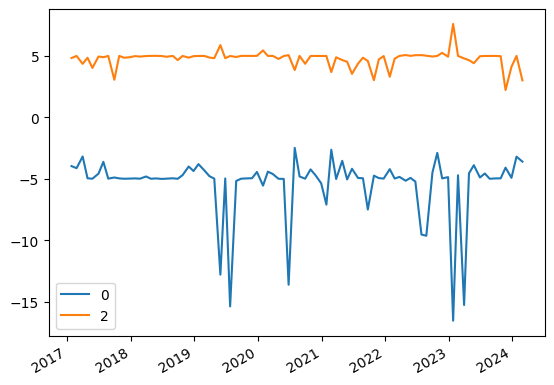

In [613]:
pd.concat(sec_comp, axis=0)[[0, 2]].plot()

In [615]:
pd.concat(sec_comp, axis=0)[[0, 2]].sort_values(0).iloc[:20]

,0,2
2023-01-27,-16.552015,7.599863
2019-07-26,-15.387978,4.993249
2023-03-31,-15.276172,4.796030
2020-06-26,-13.624846,5.061655
2019-05-31,-12.803734,5.880015
2022-08-26,-9.639999,5.016996
2022-07-29,-9.539941,5.063154
2021-09-24,-7.503171,4.586296
2021-01-29,-7.103711,4.995400
2020-01-31,-5.558153,5.446883


In [618]:
bmw.loc['2023-01-27'].dropna().sort_values()

Symbol
A000670     0.02
A003240     0.02
A284740     0.02
A014820     0.02
A280360     0.02
           ...  
A035420     2.69
A051910     2.97
A006400     3.34
A000660     4.84
A005930    28.76
Name: 2023-01-27 00:00:00, Length: 200, dtype: float64

In [623]:
daily_optw.loc['2023-01-27'].sort_values()

Symbol
A214320    0.000000
A078520    0.000000
A064960    0.000000
A060980    0.000000
A049770    0.000000
             ...   
A010130    0.033135
A047810    0.033199
A373220    0.046636
A000660    0.048386
A005930    0.168133
Name: 2023-01-27 00:00:00, Length: 284, dtype: float64

In [270]:
len(set(bmw.loc[rebal_dates[-13]].dropna().index)-set(ls_w.loc[rebal_dates[-13]].dropna().index))

0

In [299]:
daily_optw[daily_optw>0]

Symbol,A000030,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000210,A000230,...,A139130,A001570,A005420,A008730,A002710,A006110,A009970,A145720,A267260,A450080
Dates,,,,,,,,,,,,,,,,,,,,,
2017-01-26,0.00529,0.000724,0.001243,4.571634e-14,2.204581e-03,0.001869,0.000149,0.001069,0.003143,0.000154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-31,0.00529,0.000724,0.001243,4.571634e-14,2.204581e-03,0.001869,0.000149,0.001069,0.003143,0.000154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-01,0.00529,0.000724,0.001243,4.571634e-14,2.204581e-03,0.001869,0.000149,0.001069,0.003143,0.000154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-02,0.00529,0.000724,0.001243,4.571634e-14,2.204581e-03,0.001869,0.000149,0.001069,0.003143,0.000154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-03,0.00529,0.000724,0.001243,4.571634e-14,2.204581e-03,0.001869,0.000149,0.001069,0.003143,0.000154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23,NaN,NaN,NaN,5.655151e-04,3.583689e-03,0.001403,NaN,0.000623,0.000668,NaN,...,0.001043,0.002604,0.000716,6.949550e-15,0.000758,0.000927,5.856943e-15,0.000931,0.002029,0.001650
2024-02-26,NaN,NaN,NaN,5.655151e-04,3.583689e-03,0.001403,NaN,0.000623,0.000668,NaN,...,0.001043,0.002604,0.000716,6.949550e-15,0.000758,0.000927,5.856943e-15,0.000931,0.002029,0.001650
2024-02-27,NaN,NaN,NaN,5.655151e-04,3.583689e-03,0.001403,NaN,0.000623,0.000668,NaN,...,0.001043,0.002604,0.000716,6.949550e-15,0.000758,0.000927,5.856943e-15,0.000931,0.002029,0.001650


<Axes: xlabel='Dates'>

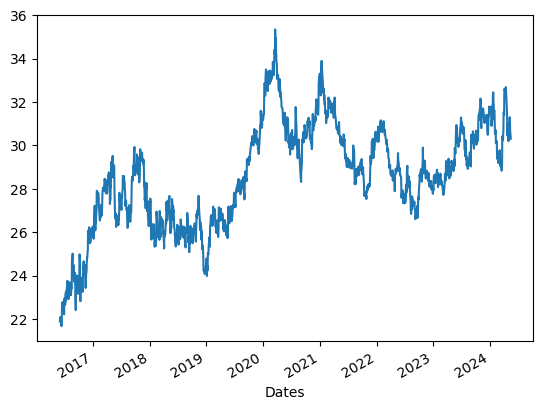

In [590]:
bmw['A005930'].plot()

<Axes: xlabel='Dates'>

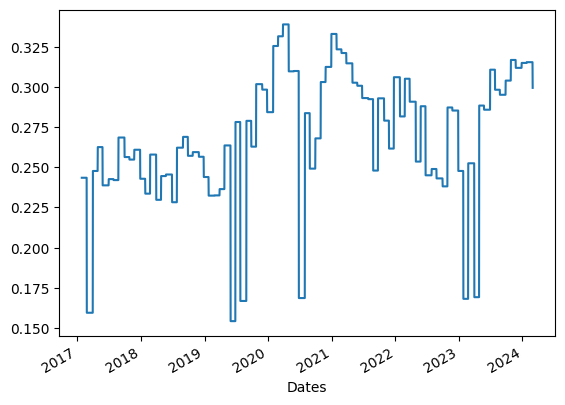

In [591]:
daily_optw['A005930'].plot()

In [301]:
sector_label.index.get_level_values(0).unique()

DatetimeIndex(['2017-01-26', '2017-02-24', '2017-03-31', '2017-04-28',
               '2017-05-26', '2017-06-30', '2017-07-28', '2017-08-25',
               '2017-09-29', '2017-10-27', '2017-11-24', '2017-12-28',
               '2018-01-26', '2018-02-23', '2018-03-30', '2018-04-27',
               '2018-05-25', '2018-06-29', '2018-07-27', '2018-08-31',
               '2018-09-28', '2018-10-26', '2018-11-30', '2018-12-28',
               '2019-01-25', '2019-02-28', '2019-03-29', '2019-04-26',
               '2019-05-31', '2019-06-28', '2019-07-26', '2019-08-30',
               '2019-09-27', '2019-10-25', '2019-11-29', '2019-12-27',
               '2020-01-31', '2020-02-28', '2020-03-27', '2020-04-29',
               '2020-05-29', '2020-06-26', '2020-07-31', '2020-08-28',
               '2020-09-29', '2020-10-30', '2020-11-27', '2020-12-30',
               '2021-01-29', '2021-02-26', '2021-03-26', '2021-04-30',
               '2021-05-28', '2021-06-25', '2021-07-30', '2021-08-27',
      

In [302]:
pd.concat([sector_label, daily_optw.stack()], axis=1).loc['2023-01-27'].dropna().sort_values(1)

,0,1
Symbol,,
A001520,소재,0.000000
A007570,의료,0.000000
A007340,경기소비재,0.000000
A071840,경기소비재,0.000000
A007210,산업재,0.000000
...,...,...
A035420,IT,0.026821
A051910,소재,0.029926
A271560,필수소비재,0.032599


In [177]:
daily_optw=daily_optw.div(daily_optw.sum(1), axis=0)

In [178]:
daily_optw.to_csv(f"../data/output/weight/202403weight_stock{stockw}_sector{sectorw}_constraint.csv")

In [179]:
daily_optret=adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]*daily_optw

/tmp/ipykernel_18261/3117912796.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_optret=adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]*daily_optw


In [282]:
daily_optret.sum(1)

Dates
2017-01-26    0.008206
2017-01-31   -0.006018
2017-02-01    0.006254
2017-02-02   -0.003198
2017-02-03    0.000770
                ...   
2024-02-23    0.001544
2024-02-26   -0.006264
2024-02-27   -0.006731
2024-02-28    0.010965
2024-02-29   -0.001896
Length: 1743, dtype: float64

In [283]:
daily_opt_cumret=(1+daily_optret.sum(1)).cumprod()

In [284]:
daily_opt_cumret

Dates
2017-01-26    1.008206
2017-01-31    1.002139
2017-02-01    1.008406
2017-02-02    1.005181
2017-02-03    1.005955
                ...   
2024-02-23    1.411365
2024-02-26    1.402524
2024-02-27    1.393083
2024-02-28    1.408358
2024-02-29    1.405689
Length: 1743, dtype: float64

In [285]:
excess_ret=(daily_optret.sum(1)-krx_idx['코스피 200'].pct_change().loc[daily_optw.index])

<Axes: xlabel='Dates'>

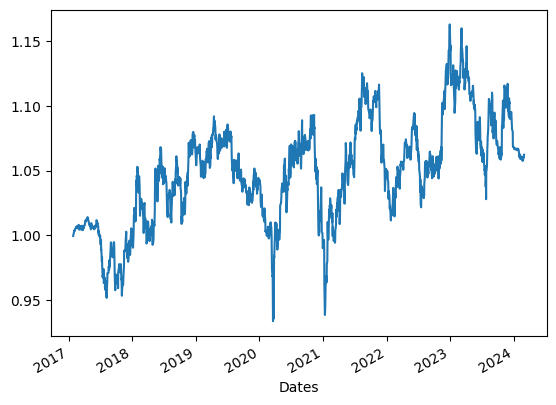

In [286]:
(1+excess_ret).cumprod().plot()

In [287]:
bm_cumret=(1+krx_idx['코스피 200'].pct_change().loc[daily_optw.index]).cumprod()

<Axes: xlabel='Dates'>

/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarnin

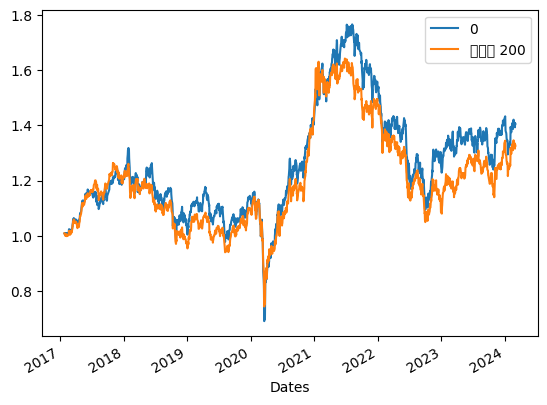

In [288]:
pd.concat([daily_opt_cumret, bm_cumret], axis=1).plot()

<Axes: xlabel='Dates'>

/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarnin

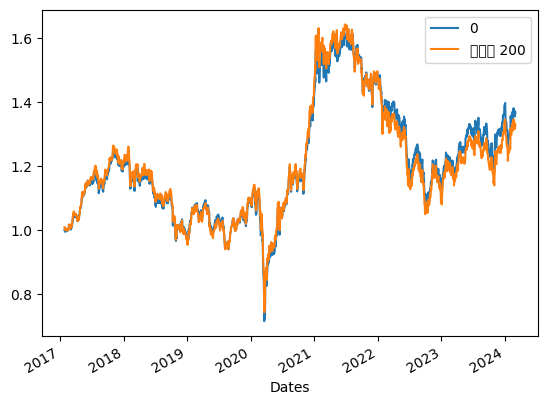

In [289]:
# 70
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(adjprc.loc[daily_optw.index, 
                                                                        daily_optw.columns], 
                                                                        daily_optw,
                                                                        cost=0.002)
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[daily_optw.index]).cumprod()], axis=1).plot()

In [188]:
a

NameError: name 'a' is not defined

In [189]:
daily_optw.iloc[-1].sort_values(ascending=False).loc[['A005930', 'A000660']]

A005930    0.296256
A000660    0.075128
Name: 2024-02-29 00:00:00, dtype: float64

In [ ]:
adjprc.loc['2023-12-25':'2024-01-02'].index

In [ ]:
recent_date='2023-12-28'
recentw=pd.DataFrame(None, index=adjprc.loc[recent_date:].index, columns=daily_optw.columns)

In [ ]:
recentw.loc[recent_date]=daily_optw.iloc[-1]

In [ ]:
recentw=recentw.ffill()

In [ ]:
recent_ret=recentw*adjprc.pct_change().loc[recentw.index, recentw.columns]

In [ ]:
(1+pd.concat([recent_ret.sum(1), krx_idx['코스피 200'].pct_change().loc[recent_date:]], axis=1)).cumprod().plot()

In [ ]:
optw_df.sort_values('opt_w')

In [ ]:
(optw_df['opt_w']-temp_bm_weight).sort_values()

In [ ]:
temp_bm_weight.sort_values()

# sector neutral


### 1. (use selection only) use top score stocks only then allocate weight proportion to the actual market cap
####  if no stock is selected in a sector then follow BM 

### 2. (use selection and score) set boundary of tilt amount and do optimization using score

### 3. (use BM and score) use entire index and tilting using optimization

In [ ]:
data_SSC_nodup.columns

In [ ]:
data_COM_nodup.columns

In [ ]:
temp_com=data_COM_nodup[['KSECapSize', 'FG_Sector_Idx', 'KOSPI200YN']].copy()

In [ ]:
temp_ssc=data_SSC_nodup[['MktCap']].copy()

In [ ]:
bm_mktcap=pd.concat([temp_com, temp_ssc], axis=1)

In [ ]:
bm_mktcap

In [ ]:
bm_mktcap=bm_mktcap[bm_mktcap['KOSPI200YN']=='Y']

In [ ]:
bm_mktcap['MktCap']=bm_mktcap['MktCap'].astype(float)


In [ ]:
bm_mktcap

In [ ]:
bm_sector_cap=bm_mktcap.groupby(['Dates', 'FG_Sector_Idx']).sum('MktCap')

In [ ]:
# bm_sector_cap=bm_mktcap.groupby(['Dates', 'FG_Sector_Idx']).sum()

In [ ]:

bm_sector_weight=bm_sector_cap /bm_mktcap.groupby(['Dates']).sum('MKtCap')

In [ ]:
# temp_mktcap.groupby(['Dates', 'FG_Sector_Idx'])['MktCap'].transform('sum')/daily_sector_weight.groupby(['Dates']).sum()

In [ ]:
bm_sector=bm_mktcap['FG_Sector_Idx'].copy()
bm_sector=bm_sector.reset_index()
bm_sector.set_index(['Dates', 'FG_Sector_Idx'], inplace=True)
bm_sector=pd.concat([bm_sector, bm_sector_weight], axis=1)
bm_sector=bm_sector.reset_index()
bm_sector.set_index(['Dates', 'Symbol'], inplace=True)

In [ ]:
# daily_sector_weight=temp_mktcap.groupby(['Dates', 'FG_Sector_Idx']).sum()/temp_mktcap.groupby(['Dates']).sum()

In [ ]:
# daily_sector_weight=bm_mktcap.groupby(['Dates', 'FG_Sector_Idx'])['MktCap'].transform('sum')
# daily_sector_weight=daily_sector_weight/daily_sector_weight.groupby(['Dates']).sum()

## stock selection from k200

In [ ]:
num_selection=75
top_prob_ls = []

for i in range(len(raw_prob.index)):
    scaler = MinMaxScaler()
    top_prob=raw_prob.iloc[i].dropna().sort_values(ascending=False)[:num_selection]
    tempw = scaler.fit_transform(top_prob.values.reshape(-1, 1))
    temp_w = pd.DataFrame(tempw, index = top_prob.index)
    top_prob_ls.append(temp_w)
    
top_prob_df=pd.concat(top_prob_ls, axis=1)
top_prob_df=top_prob_df.T
top_prob_df.index=raw_prob.index

top_prob_df=top_prob_df.stack().to_frame()
top_prob_df.index.set_names(['Dates', 'Symbol'], inplace=True)

bm_sector.columns=[bm_sector.columns[0], 'MktCap_ratio']

cap_prob_df=pd.concat([bm_mktcap, bm_sector[bm_sector.columns.difference(bm_mktcap.columns)]], axis=1)
cap_prob_df=pd.concat([cap_prob_df, k200_df['idx_weight'], top_prob_df], axis=1)
# cap_prob_df=pd.concat([cap_prob_df, top_prob_df], axis=1)

In [ ]:
cap_prob_df.dropna()

## stock selection from k100

In [ ]:
top_prob_k100_ls = []

k100prob=raw_prob * k100comp.loc[raw_prob.index]

num_selection_k100=50
for i in range(len(raw_prob.index)):
    scaler = MinMaxScaler()
    top_prob_k100=k100prob.iloc[i].dropna().sort_values(ascending=False)[:num_selection_k100]
    tempw_k100 = scaler.fit_transform(top_prob_k100.values.reshape(-1, 1))
    tempw_k100 = pd.DataFrame(tempw_k100, index = top_prob_k100.index)
    top_prob_k100_ls.append(tempw_k100)
    
top_prob_k100_df=pd.concat(top_prob_k100_ls, axis=1)
top_prob_k100_df=top_prob_k100_df.T
top_prob_k100_df.index=raw_prob.index

top_prob_k100_df=top_prob_k100_df.stack().to_frame()
top_prob_k100_df.index.set_names(['Dates', 'Symbol'], inplace=True)

bm_sector.columns=[bm_sector.columns[0], 'MktCap_ratio']

cap_prob_k100_df=pd.concat([bm_mktcap, bm_sector[bm_sector.columns.difference(bm_mktcap.columns)]], axis=1)
cap_prob_k100_df=pd.concat([cap_prob_df, k200_df['idx_weight'], top_prob_k100_df], axis=1)
# cap_prob_df=pd.concat([cap_prob_df, top_prob_df], axis=1)

## rebal dates

In [ ]:
sector_dates=cap_prob_df.dropna().index.get_level_values(0).unique()
sector_dates=pd.to_datetime(sector_dates)
sector_dates=sector_dates.sort_values()

rebal_dates = proc.find_entire_rebalancing_dates(sector_dates)
rebal_dates

In [ ]:
sector_ls=list(bm_sector['FG_Sector_Idx'].unique())
sector='IT'
given_samsung_weight=.3
sam_w=k200_df[k200_df.index.get_level_values(1)=='A005930']

## sector neutral port with samsung neutral

In [ ]:
weight_ls=[]
for date in rebal_dates:
    print(date)
    temp_sector_cap_prob=cap_prob_df[cap_prob_df.index.get_level_values(0)==date]
    
    sector_weight_ls=[]
    for sector in sector_ls:
        
        # when there is no stock in certain sector then keep all stocks in that missing sector
        if sector not in temp_sector_cap_prob.dropna()['FG_Sector_Idx'].unique():
            print(sector)
            temp_sector_neutral=temp_sector_cap_prob[temp_sector_cap_prob['FG_Sector_Idx']==sector]['idx_weight']/100
            sector_weight_ls.append(temp_sector_neutral)
            
        else:
            temp_sector_tilt=temp_sector_cap_prob[temp_sector_cap_prob['FG_Sector_Idx']==sector].dropna()
            # temp_sector_neutral['sector_ew']=1/len(temp_sector_neutral)

            if sector=='IT':
                it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
                it_mktcap=temp_sector_tilt['MktCap'].drop(index='A005930', level='Symbol')
                it_mktcap_ratio=it_mktcap/it_mktcap.sum()*it_leftover
                it_mktcap_ratio.loc[(date, 'A005930')]=given_samsung_weight
                sector_weight_ls.append(it_mktcap_ratio)
            else:
                temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
                sector_weight_ls.append(temp_mktcap_ratio)

    weight_df=pd.concat(sector_weight_ls, axis=0)
    weight_ls.append(weight_df)

In [ ]:
temp_sector_cap_prob[temp_sector_cap_prob['FG_Sector_Idx']==sector]

## smoothing weights

In [ ]:
sector_neutral_weight=pd.concat(weight_ls).unstack().dropna(how='all', axis=0)
sector_neutral_weight=sector_neutral_weight.div(sector_neutral_weight.sum(1), axis=0)

temp_adj=adjprc.loc[sector_neutral_weight.index[0]:sector_neutral_weight.index[-1], sector_neutral_weight.columns].copy()
daily_w=temp_adj.copy()
daily_w.loc[sector_neutral_weight.index]=0
daily_w[daily_w!=0]=None
daily_w.loc[sector_neutral_weight.index]=sector_neutral_weight.fillna(0)
daily_w=daily_w.fillna(method='ffill')

In [ ]:
daily_w.sum(1).plot()

In [ ]:
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(temp_adj, 
                                                                        daily_w.shift(1),
                                                                        cost=0.003)

In [ ]:
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[daily_w.index]).cumprod()], axis=1).plot()

## k200 ew port with samsung neutral

In [ ]:
top_prob_unstack=top_prob_df.unstack().copy()
top_prob_unstack.columns=top_prob_unstack.columns.get_level_values(1)

k200_weight_ls=[]
for date in rebal_dates:
    temp_top_prob=top_prob_unstack.loc[date].copy()
    ew_sum=1-sam_w.loc[date, 'idx_weight'].values/100
    
    # if samsung is in the top then add additional weight to idx weight
    if 'A005930' in temp_top_prob.index:
        temp_ew=ew_sum/75
        temp_top_prob[temp_top_prob>0]=temp_ew[0]
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100+temp_ew[0]
    else:
        temp_ew=ew_sum/76
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100
        
    k200_weight_ls.append(temp_top_prob)

# k200 market weight

In [ ]:
temp_top_prob_df=top_prob_df[top_prob_df.index.get_level_values(0).isin(rebal_dates)]

In [ ]:
k200_df.index.get_level_values(0).unique(), top_prob_df.index.get_level_values(0).unique()

In [ ]:
temp_k200_df=k200_df[k200_df.index.isin(temp_top_prob_df.index)]

In [ ]:
temp_k200_df=temp_k200_df['idx_weight'].unstack()

In [ ]:
k200_df_mask=temp_k200_df.copy()
k200_df_mask[k200_df_mask>0]=1

In [ ]:
k200_df_mask

In [ ]:
temp_samw=sam_w[sam_w.index.get_level_values(0).isin(temp_k200_df.index.get_level_values(0))]['idx_weight']
temp_samw.index=temp_samw.index.get_level_values(0)

In [ ]:
temp_k200_df['A005930']=temp_samw

In [ ]:
k200_df_mask.sum(1)

In [ ]:
extra_weight=(100-temp_k200_df.sum(1))/k200_df_mask.sum(1)

In [ ]:
temp_k200_df

In [ ]:
k200_mask_weight=k200_df_mask.multiply(extra_weight, axis=0)

In [ ]:
k200_df_mkw=(k200_mask_weight.fillna(0) + temp_k200_df)

In [ ]:
def convert_rebal_to_daily(rebal_weight, daily_df):   
    daily_w=daily_df.loc[rebal_weight.index[0]:rebal_weight.index[-1], rebal_weight.columns].copy()
    daily_w.loc[rebal_weight.index]=0
    daily_w[daily_w!=0]=None
    daily_w.loc[rebal_weight.index]=rebal_weight.fillna(0)
    daily_w=daily_w.fillna(method='ffill')    
    return daily_w

In [ ]:
k200_weight_df=pd.concat(k200_weight_ls, axis=1).T
# temp_adj=adjprc.loc[k200_weight_df.index[0]:k200_weight_df.index[-1], k200_weight_df.columns].copy()
# k200_daily_w=temp_adj.copy()
# k200_daily_w.loc[k200_weight_df.index]=0
# k200_daily_w[k200_daily_w!=0]=None
# k200_daily_w.loc[k200_weight_df.index]=k200_weight_df.fillna(0)
# k200_daily_w=k200_daily_w.fillna(method='ffill')

In [ ]:
k200_daily_w=convert_rebal_to_daily(k200_weight_df, adjprc)
k200_daily_mkw=convert_rebal_to_daily(k200_df_mkw/100, adjprc)

In [ ]:
k200_daily_w.sum(1).plot()

In [ ]:
k200_daily_mkw.sum(1).plot()

In [ ]:
k200_daily_w.columns

In [ ]:
k200_daily_w['A005930'].plot()

In [ ]:
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(adjprc.loc[k200_daily_w.index, k200_daily_w.columns], 
                                                                        k200_daily_w.shift(1),
                                                                        cost=0.00)
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k200_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf200 = perf.analyze_performance(idx_ret_cost, 
                                     model_name = 'k200',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k200_daily_w.index])

temp_perf200.T

In [ ]:
k200_daily_mkw

In [ ]:
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(adjprc.loc[k200_daily_mkw.index, 
                                                                                    k200_daily_mkw.columns], 
                                                                        k200_daily_mkw.shift(1),
                                                                        cost=0.00)
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k200_daily_mkw.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf200 = perf.analyze_performance(idx_ret_cost, 
                                     model_name = 'k200',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k200_daily_mkw.index])

temp_perf200.T

## k100 ew with samsung neutral

In [ ]:
top_prob_k100_unstack=top_prob_k100_df.unstack().copy()
top_prob_k100_unstack.columns=top_prob_k100_unstack.columns.get_level_values(1)

k100_weight_ls=[]
for date in rebal_dates:
    temp_top_prob=top_prob_k100_unstack.loc[date].copy()
    ew_sum=1-sam_w.loc[date, 'idx_weight'].values/100
    
    # if samsung is in the top then add additional weight to idx weight
    if 'A005930' in temp_top_prob.index:
        temp_ew=ew_sum/num_selection_k100
        temp_top_prob[temp_top_prob>0]=temp_ew[0]
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100+temp_ew[0]
    else:
        temp_ew=ew_sum/(num_selection_k100+1)
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100
        
    k100_weight_ls.append(temp_top_prob)    
        

In [ ]:
k100_weight_df=pd.concat(k100_weight_ls, axis=1).T
temp_adj=adjprc.loc[k100_weight_df.index[0]:k100_weight_df.index[-1], k100_weight_df.columns].copy()
k100_daily_w=temp_adj.copy()
k100_daily_w.loc[k100_weight_df.index]=0
k100_daily_w[k100_daily_w!=0]=None
k100_daily_w.loc[k100_weight_df.index]=k100_weight_df.fillna(0)
k100_daily_w=k100_daily_w.fillna(method='ffill')

In [ ]:
k100_weight_df.count(1)

In [ ]:
k100_ret, k100_ret_cost, k100_cum_ret, k100_cum_retcost = perf.return_index(temp_adj, 
                                                                        k100_daily_w.shift(1),
                                                                        cost=0.003)

### 75 ew/ 100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf75 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_75',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])



In [ ]:
temp_perf75.T

### 50 ew / 100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf50 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_50',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])

temp_perf50

### 100 ew /100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf100 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_100',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])
temp_perf100

### 30 ew / 100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf30 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_30',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])

temp_perf30

In [ ]:
pd.concat([temp_perf30, temp_perf50, temp_perf75, temp_perf100], axis=0).T

In [ ]:
sector in temp_sector_cap_prob['FG_Sector_Idx'].unique()

In [ ]:
temp_bm_sector=bm_sector.loc[date]
temp_bm_sector[temp_bm_sector['FG_Sector_Idx']==sector]

In [ ]:
temp_bm_sector.index

In [ ]:
missing_sector=temp_mktcap[temp_mktcap['FG_Sector_Idx']==sector].loc[date, 'MktCap']
missing_sector/missing_sector.sum()

In [ ]:
temp_mktcap.loc[date][temp_bm_sector.index]

In [ ]:
temp_bm_sector.index

In [ ]:
daily_sector_weight

In [ ]:
temp_sector_neutral

In [ ]:
cap_prob_df.index.get_level_values(0).unique()

In [ ]:
cap_prob_df[cap_prob_df.index.get_level_values(0)==date]